In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Things to do:

* choose relevant columns
* get dummy data
* train test split
* multiple linear regression
* lasso regression
* random forest 
* Tune Models with RandomizedSearchCV
* test ensembles


In [2]:
df = pd.read_csv('eda_data.csv')

## Choose relevant columns

In [3]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'r_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [4]:
df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly','employer provided',
             'job_state','same_state','age','python_yn','spark','aws','excel','job_simp','seniority','desc_len']]

## Get dummy data for the categorical variables

In [5]:
# for each type of categorical variable, we will create dummy data

df_dummies = pd.get_dummies(df_model)
df_dummies

,avg_salary,Rating,num_comp,hourly,employer provided,same_state,age,python_yn,spark,aws,excel,desc_len,Size_-1,Size_1 to 50 employees,Size_10000+ employees,Size_1001 to 5000 employees,Size_201 to 500 employees,Size_5001 to 10000 employees,Size_501 to 1000 employees,Size_51 to 200 employees,Size_Unknown,Type of ownership_-1,Type of ownership_College / University,Type of ownership_Company - Private,Type of ownership_Company - Public,Type of ownership_Government,Type of ownership_Hospital,Type of ownership_Nonprofit Organization,Type of ownership_Other Organization,Type of ownership_School / School District,Type of ownership_Subsidiary or Business Segment,Type of ownership_Unknown,Industry_-1,Industry_Accounting,Industry_Advertising & Marketing,Industry_Aerospace & Defense,Industry_Architectural & Engineering Services,Industry_Auctions & Galleries,Industry_Banks & Credit Unions,Industry_Beauty & Personal Accessories Stores,...,job_state_FL,job_state_GA,job_state_IA,job_state_ID,job_state_IL,job_state_IN,job_state_KS,job_state_KY,job_state_LA,job_state_MA,job_state_MD,job_state_MI,job_state_MN,job_state_MO,job_state_NC,job_state_NE,job_state_NJ,job_state_NM,job_state_NY,job_state_OH,job_state_OR,job_state_PA,job_state_RI,job_state_SC,job_state_TN,job_state_TX,job_state_UT,job_state_VA,job_state_WA,job_state_WI,job_simp_analyst,job_simp_data engineer,job_simp_data scientist,job_simp_director,job_simp_manager,job_simp_mle,job_simp_na,seniority_jr,seniority_na,seniority_senior
0,72.0,3.8,1,0,0,0,48,1,0,0,1,2536,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,87.5,3.4,1,0,0,0,37,1,0,0,0,4783,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,85.0,4.8,1,0,0,1,11,1,0,0,1,3461,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,76.5,3.8,3,0,0,1,56,1,0,0,0,3883,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,114.5,2.9,3,0,0,1,23,1,0,0,1,2728,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,84.5,3.9,3,0,0,0,191,0,0,1,0,6162,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
738,102.5,4.4,3,0,0,0,15,1,0,1,0,6130,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
739,73.5,2.6,1,0,0,1,37,0,0,0,1,3078,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
740,127.5,3.2,1,0,0,0,-1,0,0,0,1,1642,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


## Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
X = df_dummies.drop('avg_salary', axis=1)
y = df_dummies['avg_salary'].values # creates a numpy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Train --> 80% of data, Test --> 20% of data

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((593, 177), (149, 177), (593,), (149,))

## Multiple Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Scoring parameter with [cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) - after training model, evaluate model on cross-validation sets

In [9]:
from sklearn.model_selection import cross_val_score

lr_cross_val_score = np.mean(cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
lr_cross_val_score

# A huge negative score --> not a good algorithm for model

-352776712.54294044

## Lasso Regression

In [10]:
from sklearn.linear_model import Lasso

# 1)
# lasso_model = Lasso()
# lasso_model.fit(X_train,y_train)

# 2) 
# After finding out best value of alpha
lasso_model = Lasso(0.06)
lasso_model.fit(X_train,y_train)


Lasso(alpha=0.06, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [11]:
lasso_model_val_score = np.mean(cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
lasso_model_val_score

-19.820123427215503

In [12]:
# Initially the score is poor, so lets find out the value of alpha that will optimize the model

# List of values of alpha and the error associated with it
alpha = []
error = []

# alpha values from 0.1 - 1
for i in range(1,100):
  val = i/100
  alpha.append(val)
  lasso_model_test = Lasso(alpha=val)
  error.append(np.mean(cross_val_score(lasso_model_test, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1003.9349251758249, tolerance: 67.54932953586497
  positive)


In [13]:
plt.style.use("seaborn")

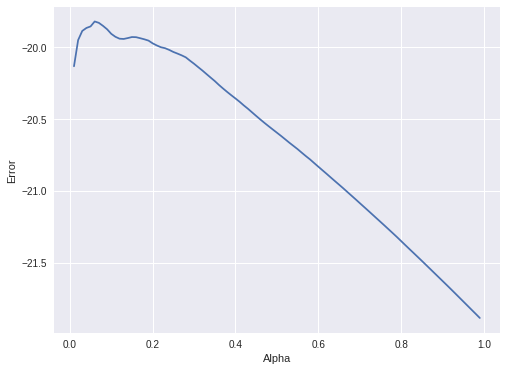

In [14]:
plt.figure(figsize=(8,6))
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.plot(alpha,error)
plt.show()

In [15]:
# Join the alpha and error lists together - as a tuple (non iterable list)
# in order to find the value of alpha for which neg error is minimun (best error - max())

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns= ['alpha','error']) # convert the merged list to a dataframe

In [16]:
df_err.head()

,alpha,error
0,0.01,-20.132077
1,0.02,-19.949703
2,0.03,-19.885995
3,0.04,-19.865362
4,0.05,-19.854649


In [17]:
df_err[df_err.error == max(df_err.error)]

,alpha,error
5,0.06,-19.820123


## Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [19]:
rf_val_score = np.mean(cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
rf_val_score

-13.437467169918815

## Tune Models ( Hyperparameter tuning) with [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

parameters = [ # list of different combination of hyperparameters that we want to test
              {'n_estimators': range(10,300,10), 'criterion': ['mse', 'mae'], 'max_features':['auto','sqrt','log2']}
]


# Setup 
random_cv = RandomizedSearchCV(estimator=rf,
                            param_distributions=parameters, 
                            scoring = 'neg_mean_absolute_error', # evaluation metric
                            cv=10, # k = 10, no. of k-train test folds (standard)
                            n_iter=10, # number of models to try
                            verbose=2, # print out the results
                            n_jobs = -1,  # set processor of machine. -1 --> means all processor will be in  use 
                            refit=True) # set refit=True (default) to refit the best model on the full dataset 

# RandomizedSearchCV is only applied on train set
random_cv.fit(X_train, y_train) 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [21]:
# get best accuracy, and the set of parameters that led to that best accuracy
best_accuracy = random_cv.best_score_
best_parameters = random_cv.best_params_
print("Best Accuracy: {:.2f}".format(best_accuracy))
print("Best Parameters:", best_parameters)

# RandomForestRegressor will be refit with best parameters 

Best Accuracy: -12.66
Best Parameters: {'n_estimators': 270, 'max_features': 'auto', 'criterion': 'mse'}


In [22]:
best_estimator = random_cv.best_estimator_
print("Best Parameters:", best_estimator)

Best Parameters: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=270, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


## Cross Validation Scores of models till now using negative MAE:
* Multiple Linear Regression = -352776712.54294044
* Lasso Regression = -19.82
* Random Forest Regressor = -12.69

## Prediction on Test Set

In [23]:
y_pred_lr = lr_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_rf = random_cv.best_estimator_.predict(X_test) # rf was tuned

1. ** R^2 or coefficient of determination** - Compares your models predictions to the mean of the targets. Gives a quick insight on how our models predictions are to close to the true predictions

2. **Mean absolute error (MAE)** - The average of the absolute differences between predictions and actual values. It gives you an idea of how wrong your predictions were.

In [24]:
from sklearn.metrics import r2_score, mean_absolute_error
print("Regression model metrics on the test set:")

Regression model metrics on the test set:


In [25]:
print(f"R^2: {r2_score(y_test, y_pred_lr):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")

# MAE is huge. The difference between the actual and predicted values are great, therfore Linear Regression is not a estimator for our model

R^2: -92689775659809.00
MAE: 38668910.50


In [26]:
print(f"R^2: {r2_score(y_test, y_pred_lasso):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso):.2f}")

R^2: 0.55
MAE: 19.09


In [27]:
df_lasso = pd.DataFrame(
    data={"actual values":y_test,
         "predicted values":y_pred_lasso
         })
df_lasso["differences"] = df_lasso["predicted values"] - df_lasso["actual values"]
df_lasso

,actual values,predicted values,differences
0,48.5,66.290004,17.790004
1,133.0,154.810587,21.810587
2,113.5,129.485889,15.985889
3,96.0,87.880081,-8.119919
4,95.0,100.301176,5.301176
...,...,...,...
144,97.5,95.756707,-1.743293
145,133.5,136.913088,3.413088
146,15.5,85.801541,70.301541
147,99.0,106.559758,7.559758


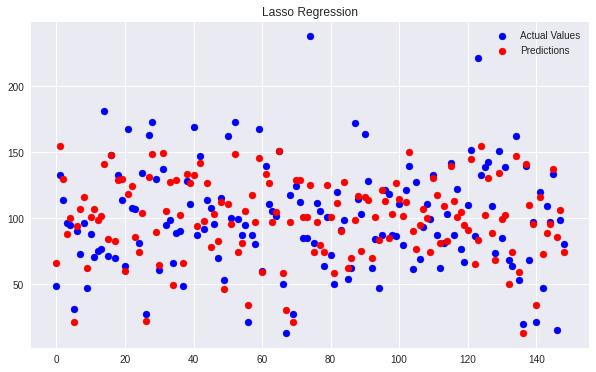

In [28]:
plt.figure(figsize=(10,6))

# np.arange() - Return evenly spaced values within a given interval.
x = np.arange(0,len(df_lasso),1)

# scatter(x,y) --> x and y must be of equal length
plt.title("Lasso Regression")
plt.scatter(x, df_lasso["actual values"], c='b', label="Actual Values")
plt.scatter(x, df_lasso["predicted values"], c='r', label="Predictions")
plt.legend()
plt.show();

In [29]:
print(f"R^2: {r2_score(y_test, y_pred_rf):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")

R^2: 0.69
MAE: 12.25


In [30]:
df_rf = pd.DataFrame(
    data={"actual values":y_test,
         "predicted values":y_pred_rf
         })
df_rf["differences"] = df_rf["predicted values"] - df_rf["actual values"]
df_rf

,actual values,predicted values,differences
0,48.5,53.294444,4.794444
1,133.0,116.824074,-16.175926
2,113.5,112.285185,-1.214815
3,96.0,95.590741,-0.409259
4,95.0,98.624074,3.624074
...,...,...,...
144,97.5,85.959259,-11.540741
145,133.5,139.555556,6.055556
146,15.5,88.925926,73.425926
147,99.0,104.992593,5.992593


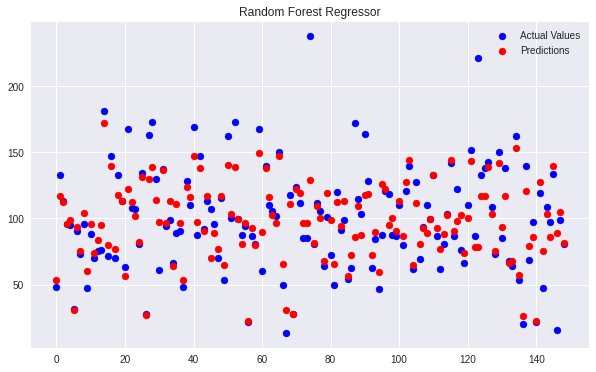

In [31]:
plt.figure(figsize=(10,6))

# np.arange() - Return evenly spaced values within a given interval.
x = np.arange(0,len(df_rf),1)

# scatter(x,y) --> x and y must be of equal length
plt.title("Random Forest Regressor")
plt.scatter(x, df_rf["actual values"], c='b', label="Actual Values")
plt.scatter(x, df_rf["predicted values"], c='r', label="Predictions")
plt.legend()
plt.show();

## Save the Model with [Pickle](https://docs.python.org/3/library/pickle.html)



In [33]:
# Save the RandomForestRegressor model that was tuned

import pickle

rf_pickle = {'model': random_cv.best_estimator_}
pickle.dump(rf_pickle,open("model_file.pkl","wb")) # .pkl --> pickle file
# "wb" string which stands for "write binary"

## Load the Model with [Pickle](https://docs.python.org/3/library/pickle.html)


In [34]:
# rb -> read binary
file_name = "model_file.pkl"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    loaded_model = data['model']

In [35]:
pickle_y_preds = loaded_model.predict(X_test) # Check if the model is loaded

In [36]:
print(f"R^2: {r2_score(y_test, pickle_y_preds):.2f}") # Make some predictions
print(f"MAE: {mean_absolute_error(y_test, pickle_y_preds):.2f}")

R^2: 0.69
MAE: 12.25


## Predict a value

In [41]:
# Take first row of X_test
loaded_model.predict(X_test.iloc[1,:].values.reshape(1,-1))

array([116.82407407])

In [42]:
list(X_test.iloc[1,:])

[3.0,
 1.0,
 0.0,
 0.0,
 1.0,
 6.0,
 1.0,
 0.0,
 1.0,
 0.0,
 3280.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 